In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv
/kaggle/input/predicting-depression-machine-learning-challenge/train.csv
/kaggle/input/predicting-depression-machine-learning-challenge/test.csv


In [40]:
train = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/train.csv')
test = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/test.csv')

submission = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv')


In [42]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

train["is_profession_missing"] = train["Profession"].notna().astype(int)
#train["is_Work_Pressure_missing"] = train["Work Pressure"].notna().astype(int)
#train["is_Job_Satisfaction_missing"] = train["Job Satisfaction"].notna().astype(int)

test["is_profession_missing"] = test["Profession"].notna().astype(int)
#test["is_Work_Pressure_missing"] = test["Work Pressure"].notna().astype(int)
#test["is_Job_Satisfaction_missing"] = test["Job Satisfaction"].notna().astype(int)

# Fill missing values
for col in ["Degree", "Financial Stress", "Dietary Habits"]:
    train[col].fillna(train[col].mode()[0],inplace=True)
    test[col].fillna(train[col].mode()[0],inplace=True)

for col in ["Work Pressure", "Job Satisfaction"]:
    train[col].fillna(train[col].median(),inplace=True)
    test[col].fillna(train[col].median(),inplace=True)

train["Profession"].fillna("Unknown",inplace=True)
test["Profession"].fillna("Unknown",inplace=True)

# Encode categorical columns
#categorical_columns = ['Gender', 'Working Professional or Student','Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


#label_encoders = {}
#for col in categorical_columns:
#    le = LabelEncoder()
#    train[col] = le.fit_transform(train[col])
#    test[col] = le.transform(test[col])  
#    label_encoders[col] = le 

import pandas as pd
import numpy as np

# Define categorical columns
categorical_columns = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

# Initialize a dictionary to store mappings
target_encodings = {}

# Loop through each categorical feature
for col in categorical_columns:
    # Compute mean target value for each category
    encoding_map = train.groupby(col)['Depression'].mean().to_dict()
    
    # Store the encoding for later use (to transform test data)
    target_encodings[col] = encoding_map
    
    # Apply encoding to train data
    train[col] = train[col].map(encoding_map)
    
    # Apply encoding to test data, replacing missing categories with global mean
    test[col] = test[col].map(encoding_map).fillna(train['Depression'].mean())  # Global mean fallback


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A valu

In [43]:
#health_status = ['Healthy', 'Unhealthy', 'Moderate', 'More Healthy', 'No Healthy', 'Less Healthy', '5 Healthy', '5 Unhealthy', 'Resistant']
Good_Health=['Healthy','More Healthy', '5 Healthy']
Bad_Health=['Unhealthy','No Healthy','Less Healthy','5 Unhealthy']
Moderate_Health=['Moderate','Resistant']
#diet_lifestyle = ['Indoor', 'Electrician', 'MCA', 'Mealy', 'Hormonal', 'Vegas', 'Male', 'Soham', 'Pratham', 'Vivaan', 'Raghav', 'Naina', 'Kolkata']
#education_occupation = ['BSc', 'Class 12', 'Academic', 'MCA']
#other = ['Gender', 'Yes', 'No Healthy', 'Mealy']

# Function to classify values
def classify(value):
    if value in Good_Health:
        return 'Good_Health'
    elif value in Bad_Health:
        return 'Bad_Health'
    elif value in Moderate_Health:
        return 'Moderate_Health'
    else:
        return 'Uncategorized'

# Apply classification
train['Dietary_Habits_new'] = train['Dietary Habits'].apply(classify)
test['Dietary_Habits_new'] = test['Dietary Habits'].apply(classify)

In [44]:
education_map = {
    "High School": ["Class 11", "Class 12"],
    
    "Diploma": [
        "B.Ed", "B.P.Ed", "L.Ed", "LCA", "RCA", "HCA", "N.Pharm", "S.Pharm", 
        "A.Ed", "E.Ed", "I.Ed", "J.Ed", "G.Ed", "K.Ed", "M.B.Ed", "M.M.Ed"
    ],
    
    "Bachelor's": [
        "B.Tech", "BE", "BSc", "B.Sc", "B.Arch", "B.B.Arch", "BBA", "B.Com", "B.Ed", "BCA",
        "B.Pharm", "BPharm", "BPA", "BHM", "B Student", "BArch", "BTech", "B.Com", "B.H", 
        "B.CA", "B.BA", "B.BCA", "B.Press", "B.B.Tech", "B.M.Com", "B.Financial Analyst"
    ],
    
    "Master's": [
        "M.Tech", "M_Tech", "MTech", "ME", "MSc", "MBA", "M.Com", "M.Ed", "MPharm", 
        "M.Pharm", "MPA", "MHM", "M.Arch", "M.S", "M. Business Analyst", "MA", "MCA", 
        "M.UI", "M.", "M.M.Ed"
    ],
    
    "Doctorate": ["PhD", "MD", "MBBS"],
    
    "Law": ["LLB", "LLBA", "LLM", "LL.Com", "LLCom", "LL B.Ed", "LLS", "LLEd"],
    
    "Other": [
        "Plumber", "Entrepreneur", "Working Professional", "Data Scientist", "HR Manager",
        "UX/UI Designer", "Business Analyst", "Doctor", "Mechanical Engineer", "Travel Consultant"
    ]
}

def map_education(value):
    for category, degrees in education_map.items():
        if value in degrees:
            return category
    return "Unknown"

train["Degree_new"] = train["Degree"].apply(map_education)
test["Degree_new"] = test["Degree"].apply(map_education)

In [45]:
def categorize(value):
    # Time-related categories
    short_duration = ['Less than 5 hours', '1-2 hours', '1-3 hours', '3-4 hours', '4-5 hours', '4-6 hours', '2-3 hours', '3-6 hours', '6 hours']
    medium_duration = ['than 5 hours','6-7 hours', '7-8 hours', '6-8 hours', '8 hours','More than 8 hours','8-9 hours','9-10 hours','9-11 hours','10-11 hours']
    long_duration = [ '9-5 hours', '9-6 hours', '10-6 hours', '20-21 hours', '60-65 hours', '50-75 hours', '40-45 hours', '45-48 hours', '55-66 hours', '45 hours', '49 hours']
    
    # Miscellaneous categories
    #ambiguous = ['Meerut', 'Pune', 'Indore', '9-5','0', '8-89 hours', 'Galesabad','Unhealthy', 'Have_you_ever_had_suicidal_thoughts', 'Work_Study_Hours', 'Sleep_Duration', 'Vivan','No']

    if value in short_duration:
        return 'Short Duration'
    elif value in medium_duration:
        return 'Medium Duration'
    elif value in long_duration:
        return 'Long Duration'
    else:
        return 'Unknown'

# Example usage
train['Sleep Duration_new'] = train['Sleep Duration'].apply(categorize)
test['Sleep Duration_new'] = test['Sleep Duration'].apply(categorize)


In [46]:
train['Sleep Duration_new'].value_counts()

Sleep Duration_new
Medium Duration    69715
Short Duration     38816
Unknown            32162
Long Duration          7
Name: count, dtype: int64

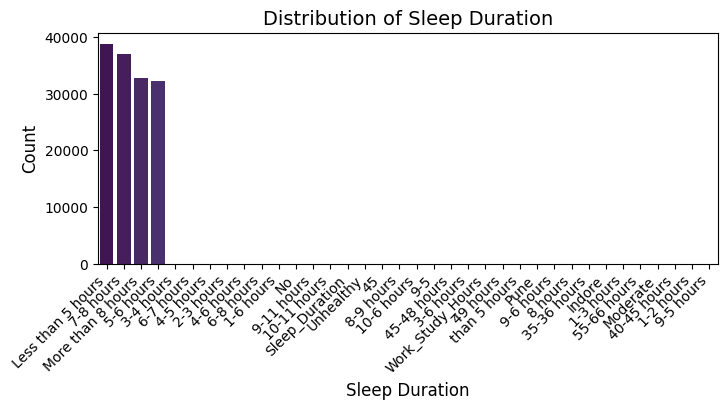

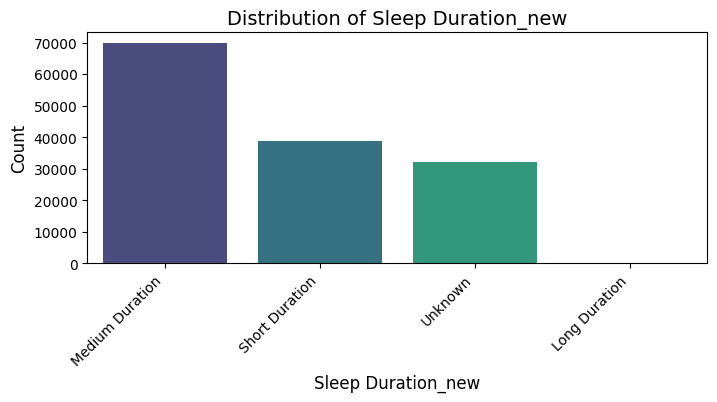

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values
profession_counts = train['Sleep Duration'].value_counts()

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette='viridis')

# Labels & Title
plt.xlabel("Sleep Duration", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Distribution of Sleep Duration", fontsize=14)

# Show the plot
plt.show()

# Count the values
profession_counts = train['Sleep Duration_new'].value_counts()

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette='viridis')

# Labels & Title
plt.xlabel("Sleep Duration_new", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Distribution of Sleep Duration_new", fontsize=14)

# Show the plot
plt.show()

In [48]:
profession_map = {
    "Education": ["Teacher", "Educational Consultant", "Academic", "B.Ed", "M.Ed"],
    "Healthcare": ["Chemist", "Pharmacist", "Medical Doctor", "Doctor", "Surgeon", "MBBS", "MD", "PhD"],
    "Engineering & Technology": ["Software Engineer", "Mechanical Engineer", "Civil Engineer", "B.Tech", "BE", "BCA", "M.Tech", "ME", "MCA", "M.Pharm"],
    "Business & Finance": ["Financial Analyst", "Investment Banker", "Business Analyst", "Manager", "City Manager", "Entrepreneur", "HR Manager", "Marketing Manager", "Sales Executive", "Consultant", "Digital Marketer"],
    "Law": ["Lawyer", "LLB", "LLBA", "LLM", "LL.Com", "LLCom", "LL B.Ed", "LLS", "LLEd"],
    "Creative & Design": ["Graphic Designer", "Content Writer", "UX/UI Designer", "Architect", "Chef", "Pilot", "Graphic Designer", "Content Writer"],
    "Trades & Services": ["Plumber", "Electrician", "Customer Support", "Travel Consultant"],
    "Research & Analysis": ["Research Analyst", "Analyst", "Researcher", "Data Scientist"],
    "Student & Academic": ["Student", "B.Com", "MBA", "BCA", "MCA", "BBA", "M.Ed"]
    #"Unclassified": ["Unemployed", "No", "Name", "FamilyVirar", "Visakhapatnam", "Yuvraj", "3M", "Manvi", "Samar", "Surat", "Pranav", "Unhealthy"]
}

def map_job(value):
    for category, titles in profession_map.items():
        if value in titles:
            return category
    return "Unknown"

train["Profession_new"] = train["Profession"].apply(map_job)
test["Profession_new"] = test["Profession"].apply(map_job)


In [49]:
cities = [
    'Agra', 'Ahmedabad', 'Bangalore', 'Bhopal', 'Chennai', 'Delhi', 'Faridabad', 'Ghaziabad', 'Gurgaon', 'Hyderabad', 'Indore', 'Jaipur', 'Kalyan',
    'Kanpur', 'Kolkata', 'Lucknow', 'Ludhiana', 'Meerut', 'Mumbai', 'Nagpur', 'Nashik', 'Patna', 'Pune', 'Rajkot', 'Srinagar', 'Surat', 'Thane', 
    'Vadodara', 'Varanasi', 'Vasai-Virar', 'Visakhapatnam'
]

def city_map(value):
    if value in cities:
        return value
    return "Unknown"

train["City_new"] = train["City"].apply(city_map)
test["City_new"] = test["City"].apply(city_map)

In [50]:
train["new_col"] = train["Work Pressure"] + train["Job Satisfaction"]

In [51]:
df =  pd.concat([train, test], axis =0)

In [52]:
#train["new_col"] = train["Work Pressure"] + train["Job Satisfaction"]

#df =  pd.concat([train, test], axis =0)

#from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

label_encoders = {}
#for col in ['City','City_new', 'Dietary Habits','Dietary_Habits_new','Sleep Duration_new','Sleep Duration','Profession','Degree']:
for col in ['Profession_new']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  

def one_hot_encode_and_add(train, column):
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = one_hot_encoder.fit_transform(train[[column]])
    encoded_columns = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out([column]))
    encoded_columns.index = train.index
    train = pd.concat([train, encoded_columns], axis=1)
    train = train.drop(columns=[column])
    return train

#columns_to_encode = ['Profession_new', 'Degree_new','In_A_City']
columns_to_encode = ['Degree_new','Sleep Duration_new','Dietary_Habits_new','City_new']

for col in columns_to_encode:
    df = one_hot_encode_and_add(df, col)


In [ ]:
import pandas as pd
import numpy as np

# Define categorical columns
categorical_columns = ['Profession_new', 'Degree_new', 'Sleep Duration_new', 'Dietary_Habits_new', 'City_new']

# Separate train and test
train_df = df[df['Depression'].notnull()]  # Assuming 'y_train' exists in df
test_df = df[df['Depression'].isnull()]    # Test data doesn't have target values

# Initialize a dictionary to store mappings
target_encodings = {}

# Apply Target Encoding
for col in categorical_columns:
    # Compute mean target value for each category
    encoding_map = train_df.groupby(col)['Depression'].mean().to_dict()
    
    # Store encoding map for later use
    target_encodings[col] = encoding_map
    
    # Apply encoding to train data
    train_df[col] = train_df[col].map(encoding_map)
    
    # Apply encoding to test data, replacing missing categories with global mean
    global_mean = train_df['Depression'].mean()  # Global mean of target
    test_df[col] = test_df[col].map(encoding_map).fillna(global_mean)

# Merge back train and test
df = pd.concat([train_df, test_df], axis=0)


In [53]:
train = df.dropna(subset=['new_col'])
test = df[df['new_col'].isna()]

test = test.drop(columns=['new_col'])
train = train.drop(columns=['new_col'])
test = test.drop(columns=['Depression'])

In [54]:
test

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,...,City_new_Pune,City_new_Rajkot,City_new_Srinagar,City_new_Surat,City_new_Thane,City_new_Unknown,City_new_Vadodara,City_new_Varanasi,City_new_Vasai-Virar,City_new_Visakhapatnam
0,140700,Shivam,0.181713,53.0,Visakhapatnam,0.081836,Judge,NaN,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,140701,Sanya,0.181713,58.0,Kolkata,0.081836,Educational Consultant,NaN,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140702,Yash,0.181713,53.0,Jaipur,0.081836,Teacher,NaN,4.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,140703,Nalini,0.181713,23.0,Rajkot,0.585499,Unknown,5.0,3.0,6.84,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,140704,Shaurya,0.181713,47.0,Kalyan,0.081836,Teacher,NaN,5.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93795,234495,Zoya,0.181713,49.0,Jaipur,0.081836,Pilot,NaN,3.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93796,234496,Shlok,0.181713,29.0,Ahmedabad,0.081836,Pilot,NaN,5.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93797,234497,Rishi,0.181713,24.0,Visakhapatnam,0.585499,Unknown,1.0,3.0,7.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93798,234498,Eshita,0.181713,23.0,Kalyan,0.081836,Marketing Manager,NaN,4.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
 
# Define target variable (change 'target_column' to the actual target name)
target = "Depression"

# Define feature columns (exclude target column)
features = [col for col in train.columns if col != target]

# Identify categorical columns
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical columns to string (CatBoost prefers them as strings)
train[categorical_features] = train[categorical_features].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.2, random_state=42
)

train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_features)


In [57]:
train.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression',
       'is_profession_missing', 'Profession_new', 'Degree_new_Bachelor's',
       'Degree_new_Diploma', 'Degree_new_Doctorate', 'Degree_new_High School',
       'Degree_new_Law', 'Degree_new_Master's', 'Degree_new_Other',
       'Degree_new_Unknown', 'Sleep Duration_new_Long Duration',
       'Sleep Duration_new_Medium Duration',
       'Sleep Duration_new_Short Duration', 'Sleep Duration_new_Unknown',
       'Dietary_Habits_new_Bad_Health', 'Dietary_Habits_new_Good_Health',
       'Dietary_Habits_new_Moderate_Health',
       'Dietary_Habits_new_Uncategorized', 'City_new_Agra',
       'City_new_Ahm

In [58]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

0:	learn: 0.6033813	test: 0.6034099	best: 0.6034099 (0)	total: 120ms	remaining: 1m
100:	learn: 0.1462017	test: 0.1496469	best: 0.1496469 (100)	total: 12.5s	remaining: 49.6s
200:	learn: 0.1384620	test: 0.1474013	best: 0.1474013 (200)	total: 24s	remaining: 35.6s
300:	learn: 0.1314749	test: 0.1465778	best: 0.1465778 (300)	total: 36.2s	remaining: 23.9s
400:	learn: 0.1262407	test: 0.1464009	best: 0.1463453 (379)	total: 48.3s	remaining: 11.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1463453144
bestIteration = 379

Shrink model to first 380 iterations.
Fold 1: Accuracy = 0.9417
0:	learn: 0.6099849	test: 0.6102003	best: 0.6102003 (0)	total: 129ms	remaining: 1m 4s
100:	learn: 0.1450454	test: 0.1559946	best: 0.1559946 (100)	total: 12.8s	remaining: 50.4s
200:	learn: 0.1369668	test: 0.1537555	best: 0.1537477 (198)	total: 24.2s	remaining: 36s
300:	learn: 0.1306827	test: 0.1531679	best: 0.1531288 (298)	total: 36.3s	remaining: 24s
400:	learn: 0.1251294	test: 0.1530729	best:

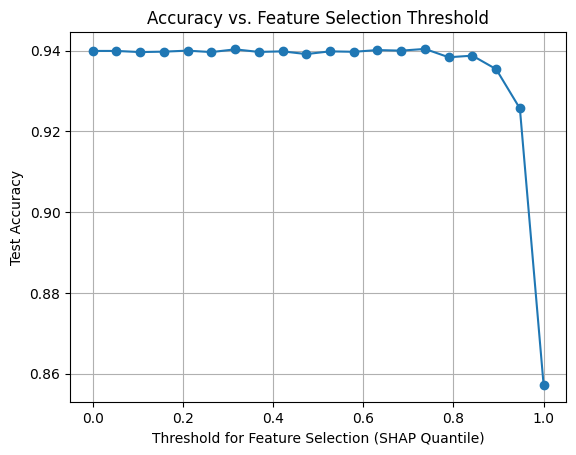

Threshold: 0.00 - Accuracy: 0.9399
Threshold: 0.05 - Accuracy: 0.9399
Threshold: 0.11 - Accuracy: 0.9397
Threshold: 0.16 - Accuracy: 0.9398
Threshold: 0.21 - Accuracy: 0.9400
Threshold: 0.26 - Accuracy: 0.9397
Threshold: 0.32 - Accuracy: 0.9403
Threshold: 0.37 - Accuracy: 0.9397
Threshold: 0.42 - Accuracy: 0.9398
Threshold: 0.47 - Accuracy: 0.9392
Threshold: 0.53 - Accuracy: 0.9398
Threshold: 0.58 - Accuracy: 0.9397
Threshold: 0.63 - Accuracy: 0.9402
Threshold: 0.68 - Accuracy: 0.9400
Threshold: 0.74 - Accuracy: 0.9404
Threshold: 0.79 - Accuracy: 0.9384
Threshold: 0.84 - Accuracy: 0.9388
Threshold: 0.89 - Accuracy: 0.9354
Threshold: 0.95 - Accuracy: 0.9257
Threshold: 1.00 - Accuracy: 0.8572

Best Threshold: 0.74 with Accuracy: 0.9404


In [59]:
#---------------------------------New Code ADDed-----------------------------
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.2, random_state=42
)

# Define categorical features (Ensure it's a list of categorical column names)
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

# Initialize Stratified K-Folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Convert to CatBoost Pool
    train_pool = Pool(X_train_fold, label=y_train_fold, cat_features=categorical_features)
    val_pool = Pool(X_val_fold, label=y_val_fold, cat_features=categorical_features)

    # Define the model
    model = CatBoostClassifier(
        iterations=500, learning_rate=0.05, max_depth=8, verbose=0
    )

    # Train model with early stopping
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=100)

    # Predict on validation set
    y_val_pred = model.predict(X_val_fold)
    
    # Compute accuracy
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    cv_scores.append(accuracy)

    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

# Print cross-validation accuracy results
print(f"\nMean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train final model on full dataset
train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)
final_model = CatBoostClassifier(iterations=500, eval_metric='AUC',
    learning_rate=0.05, max_depth=8, verbose=100
)
final_model.fit(train_pool)

# Compute SHAP values for feature selection
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_train)

# Compute mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Convert to DataFrame
shap_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP_Value': shap_importance})

# Sort features by importance
shap_df = shap_df.sort_values(by='SHAP_Value', ascending=False)
print("\nSHAP Feature Importance:")
print(shap_df)

# Define a list to store accuracy values for different thresholds
thresholds = np.linspace(0, 1, 20)  # Adjust the number of thresholds as needed
accuracies = []

# Loop over different thresholds
for threshold in thresholds:
    # Select features based on the threshold
    low_impact_features = shap_df[shap_df['SHAP_Value'] < shap_df['SHAP_Value'].quantile(threshold)]['Feature'].tolist()
    print(f"Threshold: {threshold:.2f} - Dropping {len(low_impact_features)} low-impact features")

    # Retrain with selected features
    X_train_selected = X_train.drop(columns=low_impact_features)
    X_test_selected = X_test.drop(columns=low_impact_features)

    # Update categorical features list
    categorical_features_selected = [f for f in categorical_features if f not in low_impact_features]

    # Train final model after feature selection
    train_pool_selected = Pool(X_train_selected, label=y_train, cat_features=categorical_features_selected)
    final_model_selected = CatBoostClassifier(iterations=500, eval_metric='AUC',
                                              learning_rate=0.05, max_depth=8, verbose=100)
    final_model_selected.fit(train_pool_selected)

    # Predict on test set
    y_pred = final_model_selected.predict(X_test_selected)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot the graph
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel("Threshold for Feature Selection (SHAP Quantile)")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs. Feature Selection Threshold")
plt.grid(True)
plt.show()

# Optionally, you can also print the results
for threshold, accuracy in zip(thresholds, accuracies):
    print(f"Threshold: {threshold:.2f} - Accuracy: {accuracy:.4f}")

# Final accuracy after feature selection with the best threshold (optional)
best_threshold = thresholds[np.argmax(accuracies)]
print(f"\nBest Threshold: {best_threshold:.2f} with Accuracy: {max(accuracies):.4f}")


In [60]:
# Define the best threshold
best_threshold = 0.74

# Select features based on the best threshold
low_impact_features = shap_df[shap_df['SHAP_Value'] < shap_df['SHAP_Value'].quantile(best_threshold)]['Feature'].tolist()
print(f"Threshold: {best_threshold:.2f} - Dropping {len(low_impact_features)} low-impact features")

# Remove low-impact features from the dataset
X_train_selected = X_train.drop(columns=low_impact_features)
X_test_selected = X_test.drop(columns=low_impact_features)

# Update the list of categorical features to reflect dropped features
categorical_features_selected = [f for f in categorical_features if f not in low_impact_features]

# Retrain the model on the selected features
train_pool_selected = Pool(X_train_selected, label=y_train, cat_features=categorical_features_selected)
final_model_selected = CatBoostClassifier(iterations=500, eval_metric='AUC',
                                          learning_rate=0.05, max_depth=8, verbose=100)
final_model_selected.fit(train_pool_selected)

# Predict on the test set
y_pred_selected = final_model_selected.predict(X_test_selected)

# Compute accuracy
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"\nFinal Accuracy after feature selection with threshold {best_threshold}: {accuracy_selected:.4f}")


Threshold: 0.74 - Dropping 51 low-impact features
0:	total: 137ms	remaining: 1m 8s
100:	total: 13.5s	remaining: 53.3s
200:	total: 26.5s	remaining: 39.5s
300:	total: 39.3s	remaining: 26s
400:	total: 52.2s	remaining: 12.9s
499:	total: 1m 5s	remaining: 0us

Final Accuracy after feature selection with threshold 0.74: 0.9404


In [37]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import shap
import numpy as np
import pandas as pd

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.2, random_state=42
)

# Define categorical features (Ensure it's a list of categorical column names)
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

# Initialize Stratified K-Folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Convert to CatBoost Pool
    train_pool = Pool(X_train_fold, label=y_train_fold, cat_features=categorical_features)
    val_pool = Pool(X_val_fold, label=y_val_fold, cat_features=categorical_features)

    # Define the model
    model = CatBoostClassifier(
        iterations=500, learning_rate=0.05, max_depth=8, verbose=0
    )

    # Train model with early stopping
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=100)

    # Predict on validation set
    y_val_pred = model.predict(X_val_fold)
    
    # Compute accuracy
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    cv_scores.append(accuracy)

    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

# Print cross-validation accuracy results
print(f"\nMean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train final model on full dataset
train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)
final_model = CatBoostClassifier( iterations=500, eval_metric='AUC',
    learning_rate=0.05, max_depth=8, verbose=100
)
final_model.fit(train_pool)

# Compute SHAP values for feature selection
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_train)

# Compute mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Convert to DataFrame
shap_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP_Value': shap_importance})

# Sort features by importance
shap_df = shap_df.sort_values(by='SHAP_Value', ascending=False)
print("\nSHAP Feature Importance:")
print(shap_df)

# Drop low-impact features (threshold can be adjusted)
threshold = shap_df['SHAP_Value'].quantile(0.15)  
low_impact_features = shap_df[shap_df['SHAP_Value'] < threshold]['Feature'].tolist()
print(f"\nDropping {len(low_impact_features)} low-impact features: {low_impact_features}")

# Retrain with selected features
X_train_selected = X_train.drop(columns=low_impact_features)
X_test_selected = X_test.drop(columns=low_impact_features)

# Update categorical features list
categorical_features_selected = [f for f in categorical_features if f not in low_impact_features]

# Train final model after feature selection
train_pool_selected = Pool(X_train_selected, label=y_train, cat_features=categorical_features_selected)
final_model_selected = CatBoostClassifier(iterations=500, eval_metric='AUC',
    learning_rate=0.05, max_depth=8, verbose=100
)
final_model_selected.fit(train_pool_selected)

# Predict on test set
y_pred = final_model_selected.predict(X_test_selected)

# Compute final accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy after Feature Selection: {accuracy:.4f}")


0:	learn: 0.6073270	test: 0.6072944	best: 0.6072944 (0)	total: 117ms	remaining: 58.5s
100:	learn: 0.1463266	test: 0.1500461	best: 0.1500461 (100)	total: 11.9s	remaining: 47.1s
200:	learn: 0.1385345	test: 0.1477561	best: 0.1477561 (200)	total: 23.5s	remaining: 34.9s
300:	learn: 0.1319323	test: 0.1472816	best: 0.1472608 (293)	total: 34.5s	remaining: 22.8s
400:	learn: 0.1269520	test: 0.1471558	best: 0.1471257 (381)	total: 45.8s	remaining: 11.3s
499:	learn: 0.1224185	test: 0.1470679	best: 0.1470123 (479)	total: 57.7s	remaining: 0us

bestTest = 0.1470122672
bestIteration = 479

Shrink model to first 480 iterations.
Fold 1: Accuracy = 0.9411
0:	learn: 0.6111567	test: 0.6111437	best: 0.6111437 (0)	total: 117ms	remaining: 58.4s
100:	learn: 0.1449847	test: 0.1557533	best: 0.1557533 (100)	total: 12s	remaining: 47.3s
200:	learn: 0.1368544	test: 0.1537235	best: 0.1537235 (200)	total: 23.7s	remaining: 35.3s
300:	learn: 0.1304591	test: 0.1531389	best: 0.1531169 (289)	total: 35.4s	remaining: 23.4s
40

In [61]:
# Drop low-impact features from test set
X_test_selected = test.drop(columns=low_impact_features)

# Handle missing values in categorical features
X_test_selected[categorical_features_selected] = X_test_selected[categorical_features_selected].fillna("Unknown")

# Ensure categorical features are of type string
X_test_selected[categorical_features_selected] = X_test_selected[categorical_features_selected].astype(str)

# Make predictions using the trained model
predictions = final_model_selected.predict(X_test_selected)

print("\nPredictions on test set completed!")


Predictions on test set completed!


In [62]:
predictions

array([0., 0., 0., ..., 0., 1., 0.])

In [63]:
predictions.shape

(93800,)

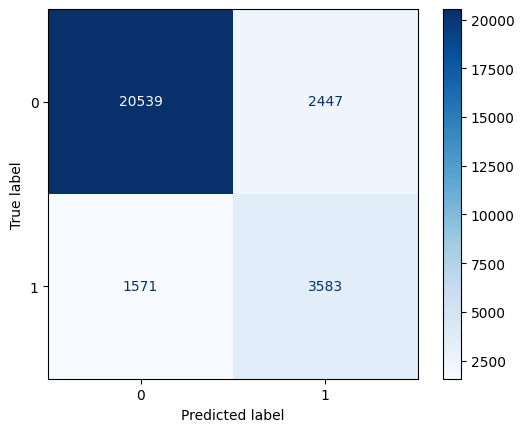

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Blues')
#cm_display.plot()


In [65]:
submission

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0
...,...,...
93795,234495,0
93796,234496,0
93797,234497,0
93798,234498,0


In [67]:
submission["Depression"] = predictions.astype(int)

In [68]:
submission

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


In [69]:
submission["Depression"].value_counts()

Depression
0    77379
1    16421
Name: count, dtype: int64

In [70]:
submission.to_csv("Submission_78.csv",index=False)